# Notebook 4 - Modelling of data derived from network analysis of metabolomic measurements from plasma samples from COVID patients. 

#### This notebook is a part of a project with the Center for Systems Biology at the University of Iceland. The goal here is to:

1. Take the results from a correlation network analysis of the untargeted metabolomic measurements of the plasma samples (which includes the module eigenvectors and the assignment of features into different modules) along with the original metabolomic dataframe and the clinical data, and create a model that is able to predict the composite outcome of the patients. 

2. After finding the modules that are most important for the prediction of composite outcomes, we look into these modules, what metabolic pathways they represent and what features are most representative of them. 

3. The most representative features (who have now been putatively annotated) are tried out as predictors of composite outcome. The results of that feature selection-based model is then compared to a model based on all >5000 features present in the untargeted metabolomic measurement. 

## Import modules:

In [1]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy import stats 
from scipy.stats import pearsonr

#sns.set(rc={"figure.figsize":(11, 10)})
#sns.set(font_scale=1)
#sns.set_style("whitegrid")
sns.reset_orig()

## Define functions

In [2]:
def impute_df(dataframe):
    '''
    A function to impute dataframe using KNN while still keeping the dataframe structure
    '''
    dat_columns = dataframe.columns
    dat_index = dataframe.index.tolist()
    imputah = KNNImputer()
    scalah = StandardScaler()
    dat_scaled = scalah.fit_transform(dataframe)
    dat_imputed = imputah.fit_transform(dat_scaled)
    dat_orig_transformed = scalah.inverse_transform(dat_imputed)
    return_df = pd.DataFrame(dat_orig_transformed, columns = dat_columns,index = dat_index)
    return return_df

def remove_columns_with_missing_data(dataframe,threshold_percentage):
    '''
    A function to remove columns from a dataframe that have more than threshold_percentage missing values
    '''
    # First remove rows that have NaN for all values:
    threshold_ = int(dataframe.shape[0]*(threshold_percentage/100))
    idx_remove = []
    for column_val in dataframe.columns:
        if dataframe[column_val].isna().sum() > threshold_:
            idx_remove.append(column_val)
    df_out = dataframe.drop(idx_remove, axis=1)
    return df_out

def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)
        
def t_test(x_dat,y_dat):
    '''
    A function to perform two sample t-test on all features in X_dat, where the rows are grouped based on y_dat.
    No correction for multiple testing takes place here, but could easily be added. 
    '''
    list_response_var = list(y_dat)
    p_vals = []
    t_vals = []
    id_group1 = indices(list_response_var,1) # Get ids of all binaries of 1
    id_group0 = indices(list_response_var,0) # Get ids of all binaries of 0
    for col in x_dat.columns:
        sample1 = x_dat.loc[id_group1,col].tolist()
        sample0 = x_dat.loc[id_group0,col].tolist()
        mean1,mean0 = np.mean(sample1), np.mean(sample0)
        std1,std0 = np.std(sample1), np.std(sample0)
        n1, n0 = len(sample1), len(sample0)
        var_sample1, var_sample0= np.var(sample1, ddof=1), np.var(sample0, ddof=1)
        var = ( ((n1-1)*var_sample1) + ((n0-1)*var_sample0) ) / (n1+n0-2)
        # standard error
        std_error = np.sqrt(var * (1.0 / n1 + 1.0 / n0))
        t = abs(mean1 - mean0) / std_error
        t_vals.append(t)
        p_two = 2*(1-stats.t.cdf(x=t, df=n1+n0-2))
        p_vals.append(p_two)
    return t_vals,p_vals

## Load data and make some adjustments to the clinical data:

In [3]:
mes = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/MEs_dataframe_24NOV2022.csv')
patients = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/patients_vector_24NOV2022.csv')
clin = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Database.csv',sep =';')
id_present = [idxx_ for idxx_,x in enumerate(clin['Subject Identifier for the Study'].tolist()) if x in patients['x'].tolist()]
clin = clin.iloc[id_present,:]
clin = clin.reset_index()

# Begin by getting only the clinical data with the non-outlier patient samples from the metabolomics network analysis: 
clin['sex_binary'] = clin['Sex']
clin['sex_binary'].replace('Male', 0,inplace=True)
clin['sex_binary'].replace('Female', 1,inplace=True)
clin['HTN_binary'] = clin['HTN']
clin['HTN_binary'].replace('Yes', 1,inplace=True)
clin['HTN_binary'].replace('No', 0,inplace=True)
clin['diabetes_binary'] = clin['Diabetes']
clin['diabetes_binary'].replace('Yes', 1,inplace=True)
clin['diabetes_binary'].replace('No', 0,inplace=True)
clin = clin.loc[:, clin.columns != 'Sex']
clin = clin.loc[:, clin.columns != 'HTN']
clin = clin.loc[:, clin.columns != 'Diabetes']

typess = clin.dtypes
for column_val in clin.columns[6:]:
    if typess[column_val] == 'O':
        clin[column_val] = clin[column_val].str.replace(',','.')
        clin[column_val] = pd.to_numeric(clin[column_val], errors='coerce')

# Remove clinical data with more than 10% missing data:
clin = remove_columns_with_missing_data(clin,20) 

# Select appropriate variables to keep in data:
clin_orig = clin.copy()
clin = clin[['sex_binary','BMI','Composite']]
clin = impute_df(clin)
clin_orig = impute_df(clin_orig)

# Round clin_orig subject identifier to integers:
clin_orig['Subject Identifier for the Study'] = round(clin_orig['Subject Identifier for the Study']).astype(int)

# Set response variable as integer:
clin['Composite'] = clin['Composite'].astype(int)
clin_orig['Composite'] = clin_orig['Composite'].astype(int)

# Load data from the network analysis in R:
mergedcolors = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/module_assignments_24NOV2022.csv')
findat = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Final_dataframe_24NOV2022.csv')
datkme = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/datkme_24NOV2022.csv')

# Prepare X and y data>
new_mes = pd.concat([mes,clin.loc[:, clin.columns != 'Composite']],axis = 1)
X = new_mes
y = clin['Composite']

## Use a grid-search to search for optimal parameters for each model, then run the LOO-fold CV to get an estimate of predictive capabilities of top modules vs all modules:

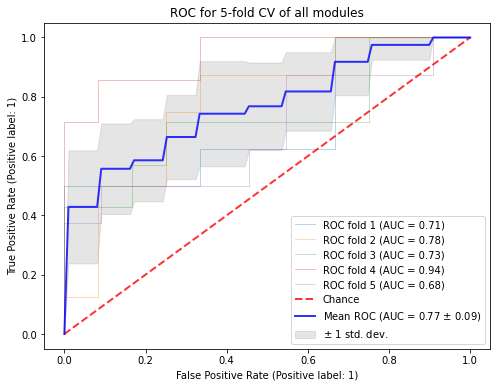

In [4]:
# Run classifier with cross-validation and plot ROC curves
X_to_use = np.array(mes)
y_to_use = y.values

classifier = RandomForestClassifier()
# Try out a grid of parameters:
parameters = {'max_features':np.arange(2,4),'n_estimators':[1000,2000],'max_depth':[2,3,4], 'random_state':[0]}
classifier_opt = GridSearchCV(classifier, parameters, cv = 5)

# Fit on entire dataset to get optimal parameters:
classifier_opt.fit(X_to_use,y_to_use)
params_to_use = classifier_opt.best_estimator_.get_params()

cv = StratifiedKFold(n_splits=5)
classifier_for_cv = RandomForestClassifier(**params_to_use)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

importance_list = []

fig, ax = plt.subplots(figsize=(8,6))
for i, (train, test) in enumerate(cv.split(X_to_use, y_to_use)):
    classifier_for_cv.fit(X_to_use[train], y_to_use[train])
    importance_list.append(classifier_for_cv.feature_importances_)
    #scores = classifier_for_cv.predict_proba(X_to_use[test])[:,1]
    #aucc = roc_auc_score(y_to_use[test],scores)
    viz = RocCurveDisplay.from_estimator(
        classifier_for_cv,
        X_to_use[test],
        y_to_use[test],
        name="ROC fold {}".format(i+1),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #fpr, tpr, thresholds = roc_curve(y_to_use[test], scores, pos_label=2)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
#mean_auc = np.mean(auc)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for 5-fold CV of all modules",
)
ax.legend(loc="lower right")
plt.show()

## Identify the most important modules:

In [5]:
sns.set(rc={"figure.figsize":(11, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")

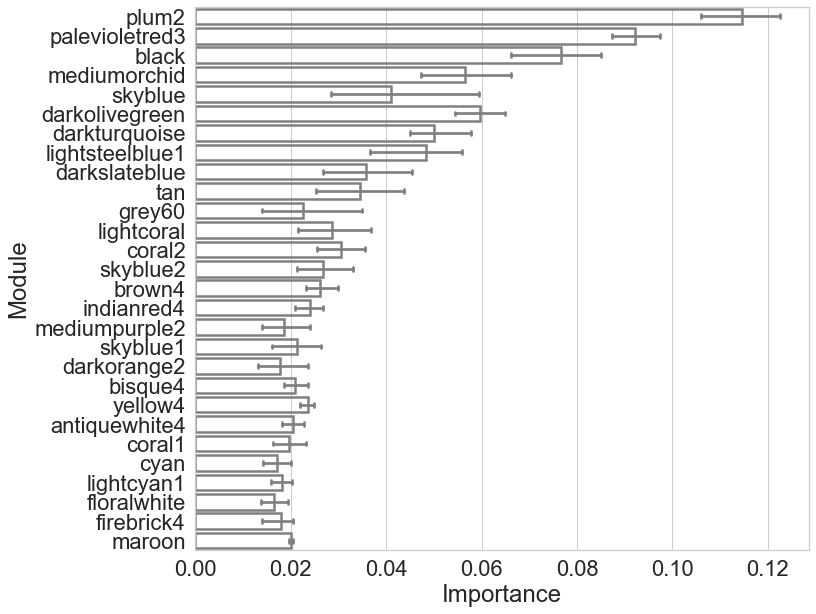

In [6]:
# Prepare an importance dataframe:
df_importance = pd.DataFrame(importance_list)
df_importance.columns = mes.columns
df_importance = df_importance.T
df_importance['Module'] = [x[2:] for x in df_importance.index.tolist()]
df_importance = df_importance.reset_index(drop=True)

# Wide to long format:
df_importance = pd.melt(df_importance, id_vars='Module',value_name='Importance')

# Rank the modules based on importance:
df_importance = df_importance.sort_values(by=['Importance'],ascending=False)

# Plot:
sns.barplot(data=df_importance, x="Importance", y="Module", 
            capsize=.2, errcolor=".5",linewidth=2.5,edgecolor=".5",
            facecolor=(1, 1, 1, 0))
plt.show()

## Try two most important modules for predicting composite outcome:

In [7]:
sns.reset_orig()

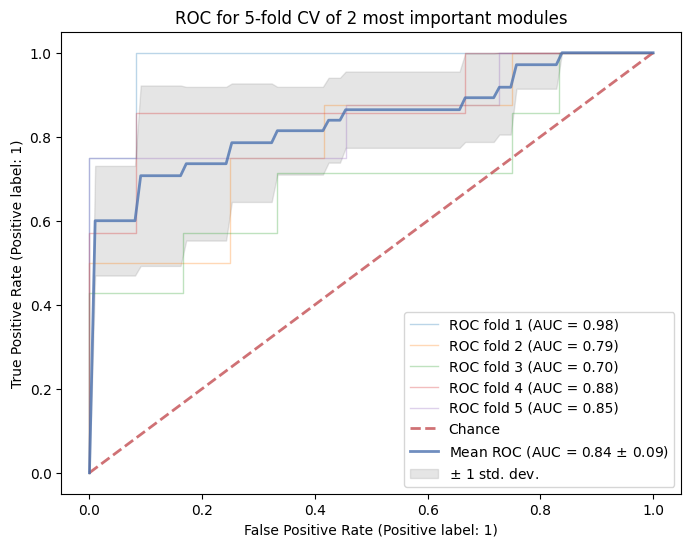

In [9]:
# Run classifier with cross-validation and plot ROC curves
X_to_use = np.array(mes.loc[:,['MEplum2','MEpalevioletred3']])
y_to_use = y.values

classifier = RandomForestClassifier()
# Try out a grid of parameters:
parameters = {'max_features':np.arange(2,4),'n_estimators':[1000,2000],'max_depth':[2,3,4], 'random_state':[0]}
classifier_opt = GridSearchCV(classifier, parameters, cv = 5)

# Fit on entire dataset to get optimal parameters:
classifier_opt.fit(X_to_use,y_to_use)
params_to_use = classifier_opt.best_estimator_.get_params()

cv = StratifiedKFold(n_splits=5)
classifier_for_cv = RandomForestClassifier(**params_to_use)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,6))
for i, (train, test) in enumerate(cv.split(X_to_use, y_to_use)):
    classifier_for_cv.fit(X_to_use[train], y_to_use[train])
    scores = classifier_for_cv.predict_proba(X_to_use[test])[:,1]
    aucc = roc_auc_score(y_to_use[test],scores)
    viz = RocCurveDisplay.from_estimator(
        classifier_for_cv,
        X_to_use[test],
        y_to_use[test],
        name="ROC fold {}".format(i+1),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #fpr, tpr, thresholds = roc_curve(y_to_use[test], scores, pos_label=2)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
#mean_auc = np.mean(auc)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for 5-fold CV of 2 most important modules",
)
ax.legend(loc="lower right")
plt.show()

### The two most important modules are clearly as good (or better) than the rest complete list of modules in predicting composite outcome. Now to confirm the modules' relationship to composite outcome, there are two things to be done:

1. Confirm that features in each module become more different between different composite outcomes the more they belong to each module. This is done quantitatively and visually by plotting the module membership values (kME from WGCNA) against a size effect describing the difference in intensities between composite outcomes (A simple t-test should suffice here).

2. Check whether the most representative feature in each important module can be used as predictors for composite outcome. 

In [25]:
sns.set(rc={"figure.figsize":(6, 7)})
sns.set_style("whitegrid")

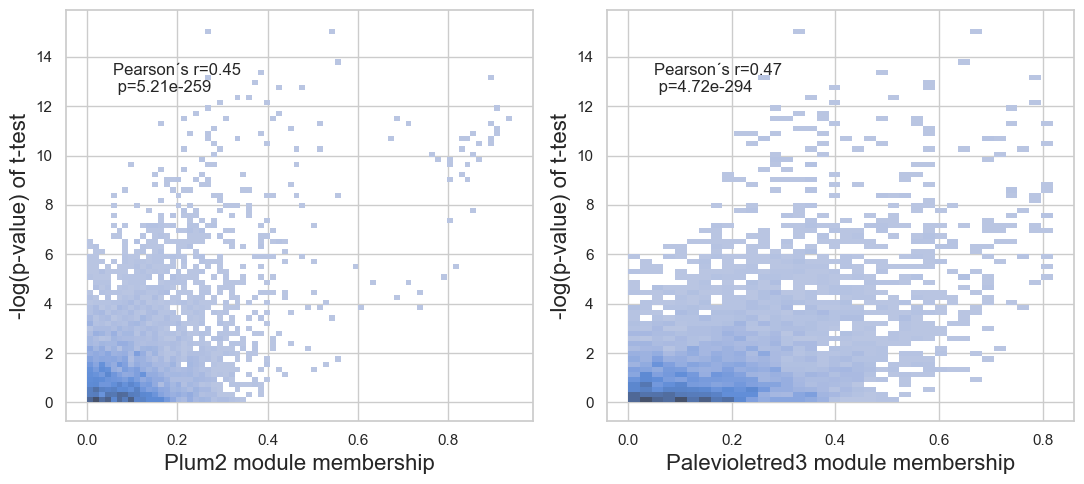

In [26]:
# Perform the t-tests:
t_vals,p_vals = t_test(findat,clin['Composite'])

# Create a dataframe with the most important modules and t- and p-values:
plot_data = pd.DataFrame([datkme['MM.plum2'].abs().tolist(),datkme['MM.palevioletred3'].abs().tolist(),t_vals,[-np.log(x) for x in p_vals]]).T
plot_data.columns = ['plum2','palevioletred3','t_vals','p_vals']

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1,2,figsize = (11,5))
# Plot p-values as a function of module membership:
sns.histplot(ax= ax[0],data=plot_data, x="plum2", y="p_vals")
ax[0].set_xlabel('Plum2 module membership', fontsize=16);
ax[0].set_ylabel('-log(p-value) of t-test', fontsize=16);

# Calculate the pearson correlation value:
r, p = pearsonr(plot_data['plum2'],plot_data['p_vals'])
ax[0].text(.1, .8, 'Pearson´s r={:.2f}\n p={:.2e}'.format(r,p), transform=ax[0].transAxes)

# Plot p-values as a function of module membership:
sns.histplot(ax = ax[1],data=plot_data, x="palevioletred3", y="p_vals")
ax[1].set_xlabel('Palevioletred3 module membership', fontsize=16);
ax[1].set_ylabel('-log(p-value) of t-test', fontsize=16)

# Calculate the pearson correlation value:
r, p = pearsonr(plot_data['palevioletred3'],plot_data['p_vals'])
ax[1].text(.1, .8, 'Pearson´s r={:.2f}\n p={:.2e}'.format(r,p), transform=ax[1].transAxes)

fig.tight_layout()

#### There is positive correlation between module membership values and t-test significance values (comparing signal intensity values in composite outcome of 1 and 0). That means that the darkolivegreen and red modules are, in fact, related to composite outcome.

## Before moving further, the modules need to be annotated (using MetaboAnalyst). To prepare the modules for annotation, there is an R script which generates a .csv file that can be uploaded directly to MetaboAnalyst

#### This will result in a particular feature being selected for each important module. The following procedure requires them to be selected beforehand. 

In [14]:
# To get the p-value threshold for the modules of interest:
modules_of_interest = ['plum2','palevioletred3']

for module in modules_of_interest:
    module_tmp = 'ME'+module
    tmp_val = round(mergedcolors['x'].value_counts()[module_tmp[2:]]/len(mergedcolors),4)
    print('p-value threshold for',module,'module is',tmp_val)

p-value threshold for plum2 module is 0.0074
p-value threshold for palevioletred3 module is 0.035


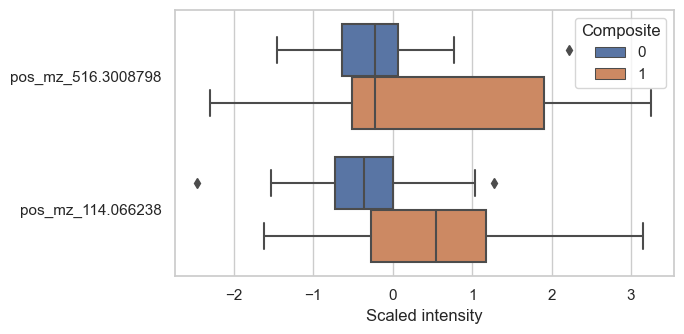

2551             plum2
1721    palevioletred3
Name: x, dtype: object


In [15]:
#my_top_feature = ['pos_mz_516.3008','pos_mz_182.0808'] # Taurocholic acid and Tyrosine according to MetaboAnalyst
my_top_feature = ['pos_mz_516.3008','pos_mz_114.0662'] # Taurocholic acid and Creatinine according to MetaboAnalyst



# Find their location in the original dataframe to move forward with modeling:
findat_shortnames = [x[:15] for x in findat.columns.tolist()]

my_top_feature_id = []
for feature in my_top_feature:
    my_top_feature_id.append(indices(findat_shortnames,feature)[0])
    
new_df = pd.concat([findat.iloc[:,my_top_feature_id],clin['Composite']],axis = 1)
new_df_long = new_df.melt(id_vars=['Composite'],value_name='Scaled intensity')
ax = sns.boxplot(data=new_df_long, x="Scaled intensity", y="variable", orient="h", hue="Composite")
ax.set(ylabel=None)
plt.tight_layout()
plt.show()

# Check which module the features in the above plot belong to (SANITY CHECK):
print(mergedcolors['x'][my_top_feature_id])

## Plot ROCs from random forest model built from the top features:

In [16]:
sns.reset_orig()

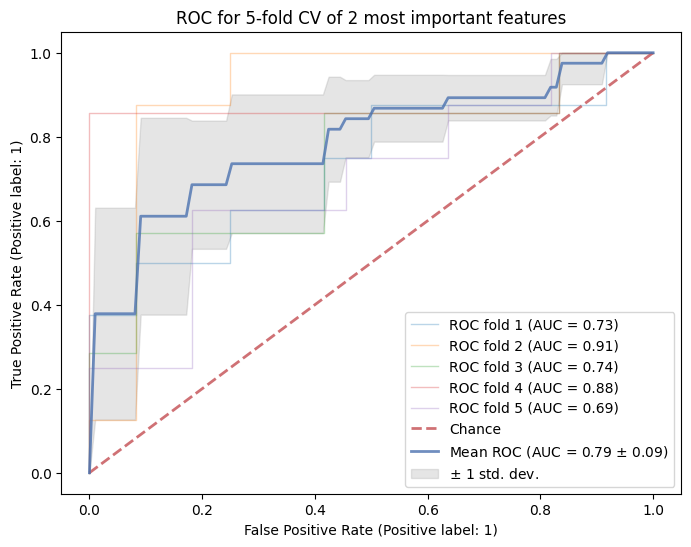

In [17]:
# Run classifier with cross-validation and plot ROC curves
X_to_use = np.array(findat.iloc[:,my_top_feature_id])
#X_to_use = np.array(findat)
y_to_use = y.values

classifier = RandomForestClassifier()
# Try out a grid of parameters:
parameters = {'max_features':np.arange(2,4),'n_estimators':[1000,2000],'max_depth':[2,3,4], 'random_state':[0]}
classifier_opt = GridSearchCV(classifier, parameters, cv = 5)

# Fit on entire dataset to get optimal parameters:
classifier_opt.fit(X_to_use,y_to_use)
params_to_use = classifier_opt.best_estimator_.get_params()

cv = StratifiedKFold(n_splits=5)
classifier_for_cv = RandomForestClassifier(**params_to_use)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,6))
for i, (train, test) in enumerate(cv.split(X_to_use, y_to_use)):
    classifier_for_cv.fit(X_to_use[train], y_to_use[train])
    viz = RocCurveDisplay.from_estimator(
        classifier_for_cv,
        X_to_use[test],
        y_to_use[test],
        name="ROC fold {}".format(i+1),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for 5-fold CV of 2 most important features",
)
ax.legend(loc="lower right")
plt.show()

## Plot ROCs from random forest model built from all features:

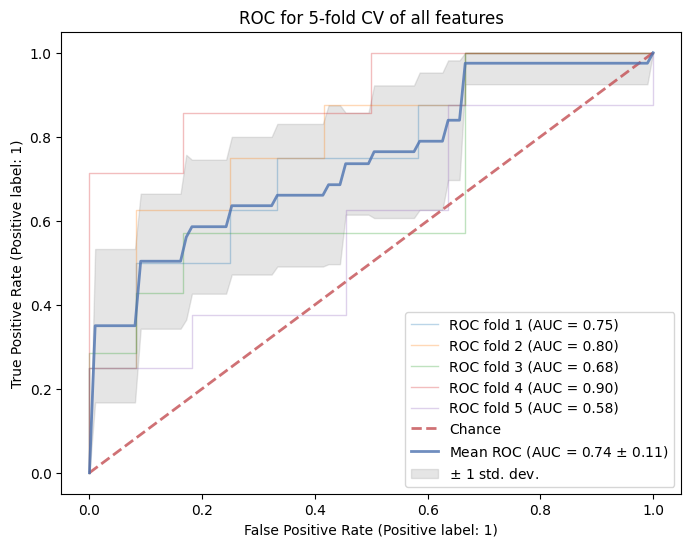

In [18]:
# Run classifier with cross-validation and plot ROC curves
X_to_use = np.array(findat)
y_to_use = y.values

classifier = RandomForestClassifier()
# Try out a grid of parameters:
parameters = {'max_features':np.arange(2,4),'n_estimators':[1000,2000],'max_depth':[2,3,4], 'random_state':[0]}
classifier_opt = GridSearchCV(classifier, parameters, cv = 5)

# Fit on entire dataset to get optimal parameters:
classifier_opt.fit(X_to_use,y_to_use)
params_to_use = classifier_opt.best_estimator_.get_params()

cv = StratifiedKFold(n_splits=5)
classifier_for_cv = RandomForestClassifier(**params_to_use)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,6))
for i, (train, test) in enumerate(cv.split(X_to_use, y_to_use)):
    classifier_for_cv.fit(X_to_use[train], y_to_use[train])
    viz = RocCurveDisplay.from_estimator(
        classifier_for_cv,
        X_to_use[test],
        y_to_use[test],
        name="ROC fold {}".format(i+1),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for 5-fold CV of all features",
)
ax.legend(loc="lower right")
plt.show()

## For determining patients that have high intensity values in features in both important modules:

In [21]:
patient_df = findat.iloc[:,my_top_feature_id]
patient_df['Patient ID'] = [str(int(x)) for x in clin_orig['Subject Identifier for the Study'].tolist()]
patient_df = patient_df.sort_values(by = ['pos_mz_516.3008798'],ascending=False)
patient_df = patient_df.reset_index(drop=True)

C:\Users\sigurdur.karvelsson\AppData\Local\Temp\ipykernel_23292\858372475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df['Patient ID'] = [str(int(x)) for x in clin_orig['Subject Identifier for the Study'].tolist()]


In [22]:
sns.set(rc={"figure.figsize":(16, 5)})
sns.set(font_scale=1)
sns.set_style("whitegrid")

C:\Users\sigurdur.karvelsson\AppData\Local\Temp\ipykernel_23292\3132984928.py:3: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(plot)


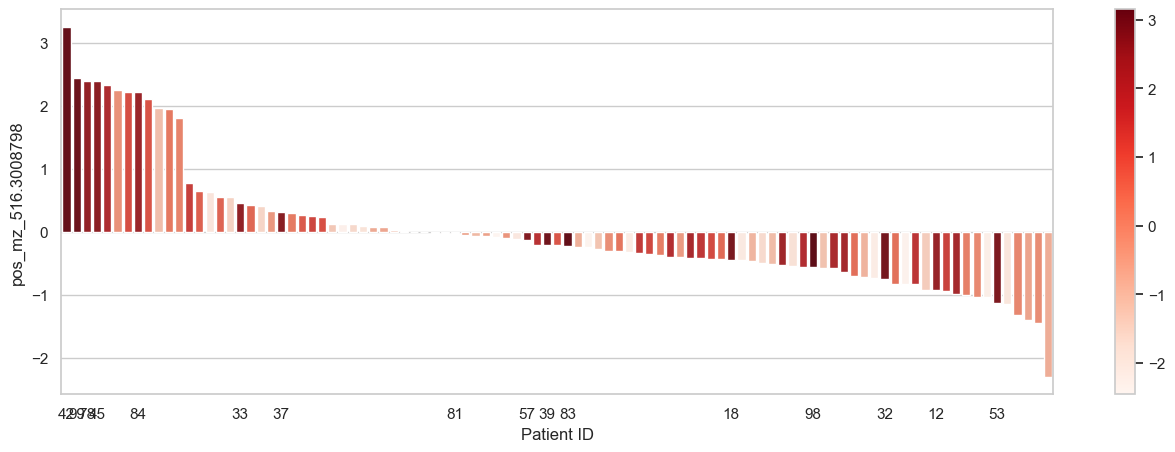

In [24]:
plot = plt.scatter(x=patient_df["Patient ID"], y=patient_df["pos_mz_516.3008798"], c=patient_df['pos_mz_114.066238'], cmap='Reds')
plt.clf()
plt.colorbar(plot)
ax = sns.barplot(x=patient_df["Patient ID"], y=patient_df["pos_mz_516.3008798"], hue=patient_df['pos_mz_114.066238'], palette='Reds', dodge=False)
for ind, label in enumerate(ax.get_xticklabels()):
    if patient_df.loc[ind,['pos_mz_114.066238']][0] > 0.9:
    #print(label)
    #if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.legend_.remove()